# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**
- $L_j = 0$: Job ist **pünktlich**
- $L_j < 0$: Job ist **zu früh** fertig

In [39]:
import pandas as pd

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.rolling_process.rolling_filter import *
from src.utils.editor import enrich_schedule_dframe

from src.utils.logging import print_experiment_log

# Analysis utils
from src.utils.analysis_basics import check_constraints as check
from src.utils.analysis_basics.check_lateness import get_jobs_with_lateness_metrics, get_jobs_aggregated
from src.utils.analysis.compare_sequences import get_comparison_dataframe, compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Solver
from src.solvers.converter import get_job_ops_dict, get_times_dict, get_schedule_dframe, get_active_ops
from src.solvers.cp.lateness import solve_jssp_lateness_with_start_deviation_minimization, \
    solve_jssp_lateness_with_order_deviation_minimization

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [40]:
# Hard termination condition for schedulers
max_time = 60*3     # 3 min

# File paths
examples_data_path = get_path("data", "examples")
basic_data_path = get_path("data", "basic")

# Simulation
simulation = ProductionSimulation(sigma = 0.2)

In [41]:
# Load files
df_routings = pd.read_csv(basic_data_path / "ft10_routings.csv")
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


In [42]:
df_jobs_times = pd.read_csv(basic_data_path / "ft10_jobs_times.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,79,1440,597,3660
1,J25-0001,6,129,1440,416,2338
2,J25-0002,0,198,1440,395,3744
3,J25-0003,2,243,1440,568,3379
4,J25-0004,3,287,1440,655,4856
5,J25-0005,1,498,1440,510,3106
...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,655,520389
7245,J25-7245,9,518089,518400,540,519640
7246,J25-7246,6,518116,518400,416,520157


In [43]:
df_jssp = df_jobs_times[["Job", "Routing_ID"]].merge(df_routings, on="Routing_ID",how="left")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [44]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [45]:
# New and unfinished jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,79,1440,597,3660
1,J25-0001,6,129,1440,416,2338
2,J25-0002,0,198,1440,395,3744
3,J25-0003,2,243,1440,568,3379
4,J25-0004,3,287,1440,655,4856
5,J25-0005,1,498,1440,510,3106
6,J25-0006,9,790,1440,540,3539
7,J25-0007,5,925,1440,496,2929
8,J25-0008,4,988,1440,393,3541
9,J25-0009,7,1004,1440,539,3578


In [46]:
# current JSSP (Job Shop Scheduling Problem) basic data
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current, exclusion_dataframes_list = None)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


### Scheduling Preperation

In [47]:
job_ops_dict = get_job_ops_dict(df_jssp_current)
job_ops_dict

{'J25-0000': [(0, 'M00', 76),
  (1, 'M01', 69),
  (2, 'M03', 76),
  (3, 'M05', 51),
  (4, 'M02', 85),
  (5, 'M09', 11),
  (6, 'M06', 40),
  (7, 'M07', 89),
  (8, 'M04', 26),
  (9, 'M08', 74)],
 'J25-0001': [(0, 'M01', 46),
  (1, 'M00', 37),
  (2, 'M03', 61),
  (3, 'M02', 13),
  (4, 'M06', 32),
  (5, 'M05', 21),
  (6, 'M09', 32),
  (7, 'M08', 89),
  (8, 'M07', 30),
  (9, 'M04', 55)],
 'J25-0002': [(0, 'M00', 29),
  (1, 'M01', 78),
  (2, 'M02', 9),
  (3, 'M03', 36),
  (4, 'M04', 49),
  (5, 'M05', 11),
  (6, 'M06', 62),
  (7, 'M07', 56),
  (8, 'M08', 44),
  (9, 'M09', 21)],
 'J25-0003': [(0, 'M01', 91),
  (1, 'M00', 85),
  (2, 'M03', 39),
  (3, 'M02', 74),
  (4, 'M08', 90),
  (5, 'M05', 10),
  (6, 'M07', 12),
  (7, 'M06', 89),
  (8, 'M09', 45),
  (9, 'M04', 33)],
 'J25-0004': [(0, 'M01', 81),
  (1, 'M02', 95),
  (2, 'M00', 71),
  (3, 'M04', 99),
  (4, 'M06', 9),
  (5, 'M08', 52),
  (6, 'M07', 85),
  (7, 'M03', 98),
  (8, 'M09', 22),
  (9, 'M05', 43)],
 'J25-0005': [(0, 'M00', 43),
  (1, '

In [48]:
times_dict = get_times_dict(df_jobs_times_current)
times_dict

{'J25-0000': (1440, 3660),
 'J25-0001': (1440, 2338),
 'J25-0002': (1440, 3744),
 'J25-0003': (1440, 3379),
 'J25-0004': (1440, 4856),
 'J25-0005': (1440, 3106),
 'J25-0006': (1440, 3539),
 'J25-0007': (1440, 2929),
 'J25-0008': (1440, 3541),
 'J25-0009': (1440, 3578),
 'J25-0010': (1440, 3345),
 'J25-0011': (1440, 3210),
 'J25-0012': (1440, 4385),
 'J25-0013': (1440, 2567),
 'J25-0014': (1440, 3315),
 'J25-0015': (1440, 2981)}

### Schedule

In [49]:
schedule, _ = solve_jssp_lateness_with_start_deviation_minimization(
        job_ops=job_ops_dict,
        times_dict=times_dict,
        previous_schedule=None,
        active_ops=None,
        w_t= 10, w_e=2, w_first=1,
        main_pct=1, duration_buffer_factor = 2,
        schedule_start=day_start, msg=False,
        solver_time_limit=max_time, solver_relative_gap_limit=0.05
    )

In [50]:
df_schedule = get_schedule_dframe(schedule)
df_schedule.to_csv(examples_data_path / "lateness_schedule_day_01.csv", index=False)
df_schedule

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,2481,76,2557
1,J25-0000,1,M01,2594,69,2663
2,J25-0000,2,M03,2681,76,2757
3,J25-0000,3,M05,2783,51,2834
4,J25-0000,4,M02,2834,85,2919
5,J25-0000,5,M09,2970,11,2981
...,...,...,...,...,...,...
154,J25-0015,4,M08,2277,48,2325
155,J25-0015,5,M09,2325,72,2397
156,J25-0015,6,M00,2434,47,2481


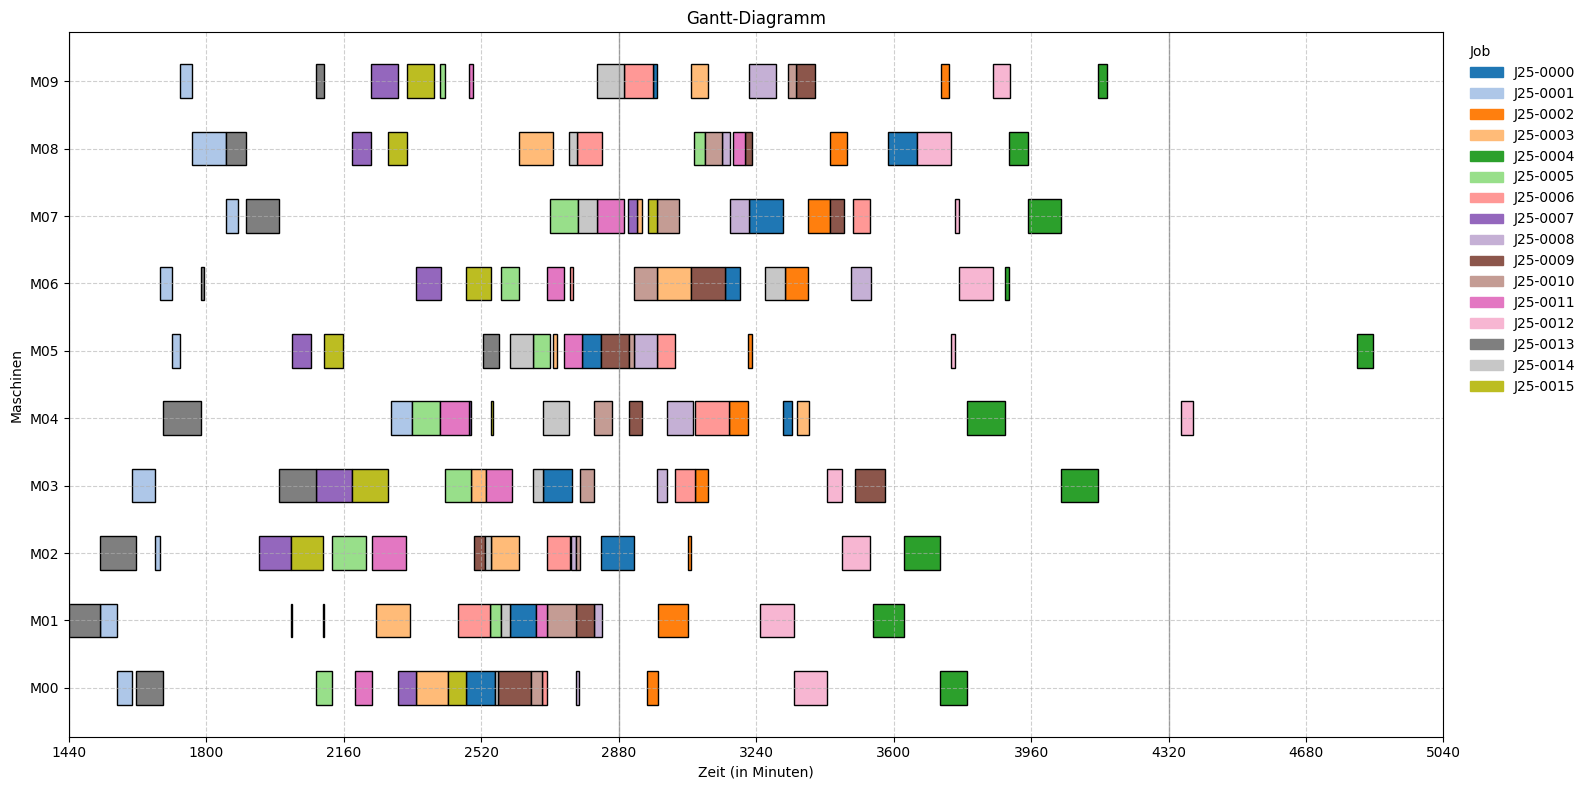

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [51]:
gantt.get_plot(df_schedule, perspective="Machine")
#df_schedule_with_info = enrich_schedule_dframe(df_schedule, df_jobs_times)
check.check_core_schedule_constraints(df_schedule)
check.is_start_correct(df_schedule, df_jobs_times_current)
check.is_duration_correct(df_schedule)


### Simulation

In [52]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 01:26:00] Job J25-0013 finished on M01 (after 86 minutes)
[Day 1 01:26:00] Job J25-0001 started on M01
[Day 1 01:26:00] Job J25-0013 started on M02
[Day 1 01:58:00] Job J25-0001 finished on M01 (after 32 minutes)
[Day 1 02:07:00] Job J25-0001 started on M00
[Day 1 02:29:00] Job J25-0001 finished on M00 (after 22 minutes)
[Day 1 02:44:00] Job J25-0001 started on M03
[Day 1 02:52:00] Job J25-0013 finished on M02 (after 86 minutes)
[Day 1 02:56:00] Job J25-0013 started on M00
[Day 1 04:05:00] Job J25-0013 finished on M00 (after 69 minutes)
[Day 1 04:07:00] Job J25-0013 started on M04
[Day 1 04:14:00] Job J25-0001 finished on M03 (after 90 minutes)
[Day 1 04:14:00] Job J25-0001 started on M02
[Day 1 04:27:00] Job J25-0001 finished on M02 (after 13 minutes)
[Day 1 04:27:00] Job J25-0001 started on M06
[Day 1 05:03:00] Job J25-0001 finished on M06 (after 36 minutes)
[Day 1 05:03:00] Job J25-0001 started on M05
[Day 1 05:20:00] Job J25-0001 

In [53]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,2514.0,66.0,2580.0
1,J25-0000,1,M01,2594.0,65.0,2659.0
2,J25-0000,2,M03,2681.0,93.0,2774.0
3,J25-0001,0,M01,1526.0,32.0,1558.0
4,J25-0001,1,M00,1567.0,22.0,1589.0
5,J25-0001,2,M03,1604.0,90.0,1694.0
...,...,...,...,...,...,...
79,J25-0015,3,M03,2239.0,84.0,2323.0
80,J25-0015,4,M08,2323.0,39.0,2362.0
81,J25-0015,5,M09,2363.0,65.0,2428.0


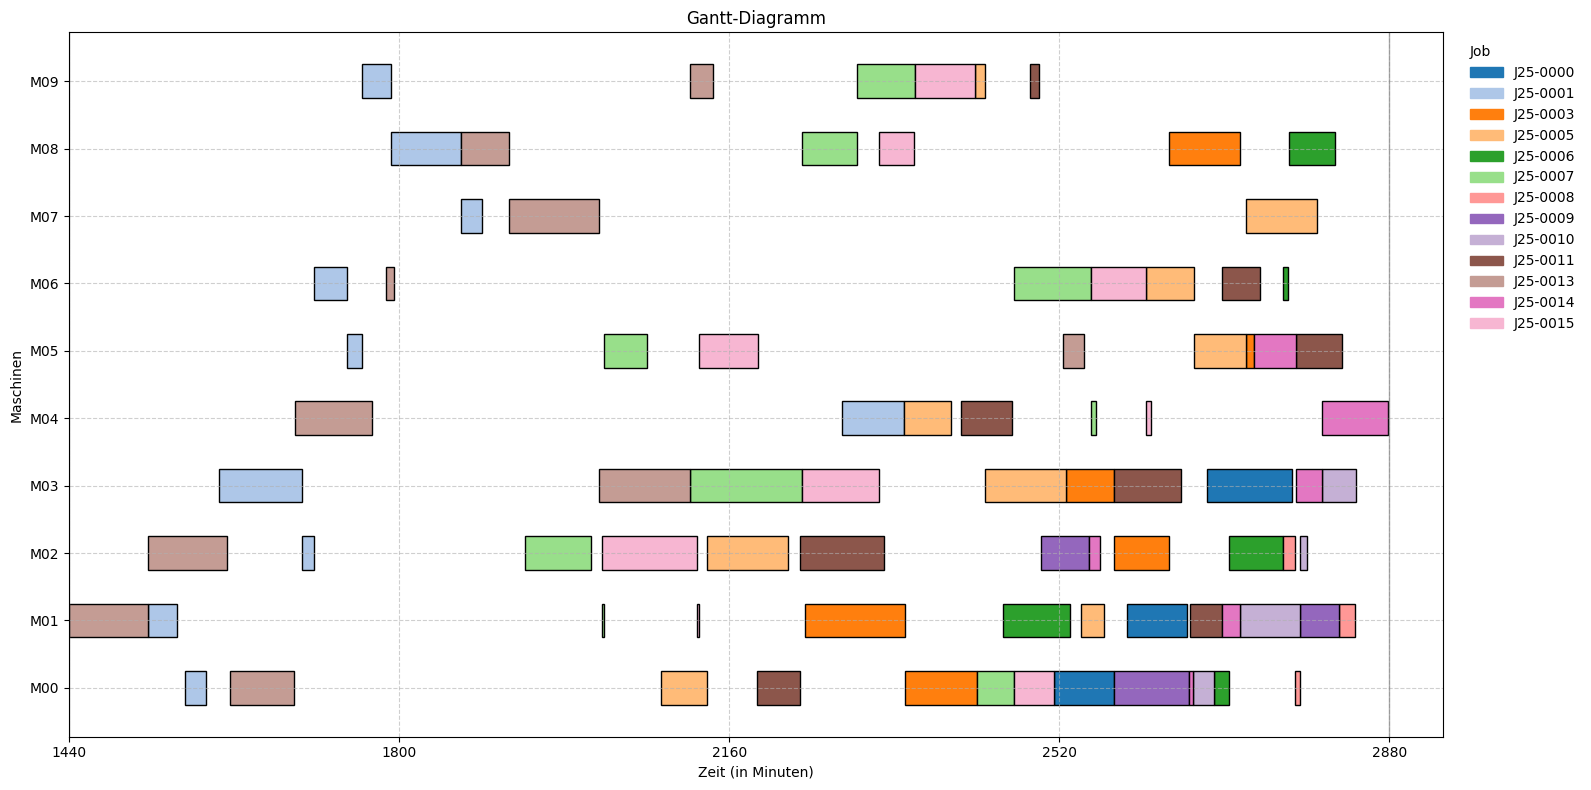

In [54]:
gantt.get_plot(df_execution, perspective="Machine")

In [55]:
df_active = simulation.get_active_operations_df()
df_active

,Job,Operation,Machine,Start,Processing Time,End,Expected End
0,J25-0000,3,M05,2828.0,62.0,2890.0,2879.0
1,J25-0010,4,M04,2879.0,57.0,2936.0,2928.0
2,J25-0011,8,M07,2828.0,72.0,2900.0,2900.0
3,J25-0014,6,M08,2879.0,22.0,2901.0,2900.0


In [56]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,4,M02,2834,85,2919
1,J25-0000,5,M09,2970,11,2981
2,J25-0000,6,M06,3158,40,3198
3,J25-0000,7,M07,3220,89,3309
4,J25-0000,8,M04,3309,26,3335
5,J25-0000,9,M08,3586,74,3660
...,...,...,...,...,...,...
65,J25-0012,8,M09,3861,45,3906
66,J25-0012,9,M04,4352,33,4385
67,J25-0014,7,M07,2773,49,2822


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [57]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [58]:
# New and unfinished jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,Job Processing Time,Deadline
0,J25-0000,8,79,1440,597,3660
2,J25-0002,0,198,1440,395,3744
3,J25-0003,2,243,1440,568,3379
4,J25-0004,3,287,1440,655,4856
5,J25-0005,1,498,1440,510,3106
6,J25-0006,9,790,1440,540,3539
...,...,...,...,...,...,...
32,J25-0032,6,2654,2880,416,3881
33,J25-0033,2,2660,2880,568,6738
34,J25-0034,8,2715,2880,597,6387


In [59]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
6,J25-0000,8,6,M06,40
7,J25-0000,8,7,M07,89
8,J25-0000,8,8,M04,26
9,J25-0000,8,9,M08,74
...,...,...,...,...,...
374,J25-0037,7,4,M04,32
375,J25-0037,7,5,M06,88
376,J25-0037,7,6,M08,19


### Scheduling Preparation

In [60]:
# jssp dict and job times information dict
job_ops_dict = get_job_ops_dict(df_jssp_current)
times_dict = get_times_dict(df_jobs_times_current)

In [61]:
active_ops = get_active_ops(df_active)
active_ops

[('J25-0000', 3, 'M05', 2828, 62, 2890),
 ('J25-0010', 4, 'M04', 2879, 57, 2936),
 ('J25-0011', 8, 'M07', 2828, 72, 2900),
 ('J25-0014', 6, 'M08', 2879, 22, 2901)]

In [62]:
previous_schedule = schedule
df_previous_schedule = df_schedule

### Scheduling (Rescheduling)

#### a) Simple Scheduling


===== EXPERIMENT LOG SUMMARY =====
[EXPERIMENT_INFO]
  total_number_of_operations                        : 291
  number_of_operations_with_previous_schedule       : 0
  number_of_active_operation_to_consider            : 4
  schedule_start                                    : 2880
[EXPERIMENT_CONFIG]
  main_pct                                          : 1.0
  w_t                                               : 5
  w_e                                               : 1
  w_first                                           : 1
  deviation_type                                    : start
  solver_time_limit                                 : 180
  solver_relative_gap_limit                         : 0.05
[MODEL_INFO]
  number_of_variables                               : 803
  number_of_constraints                             : 1072
  number_of_deviation_terms                         : 0
[SOLVER_INFO]
  status                                            : OPTIMAL
  objective_value               

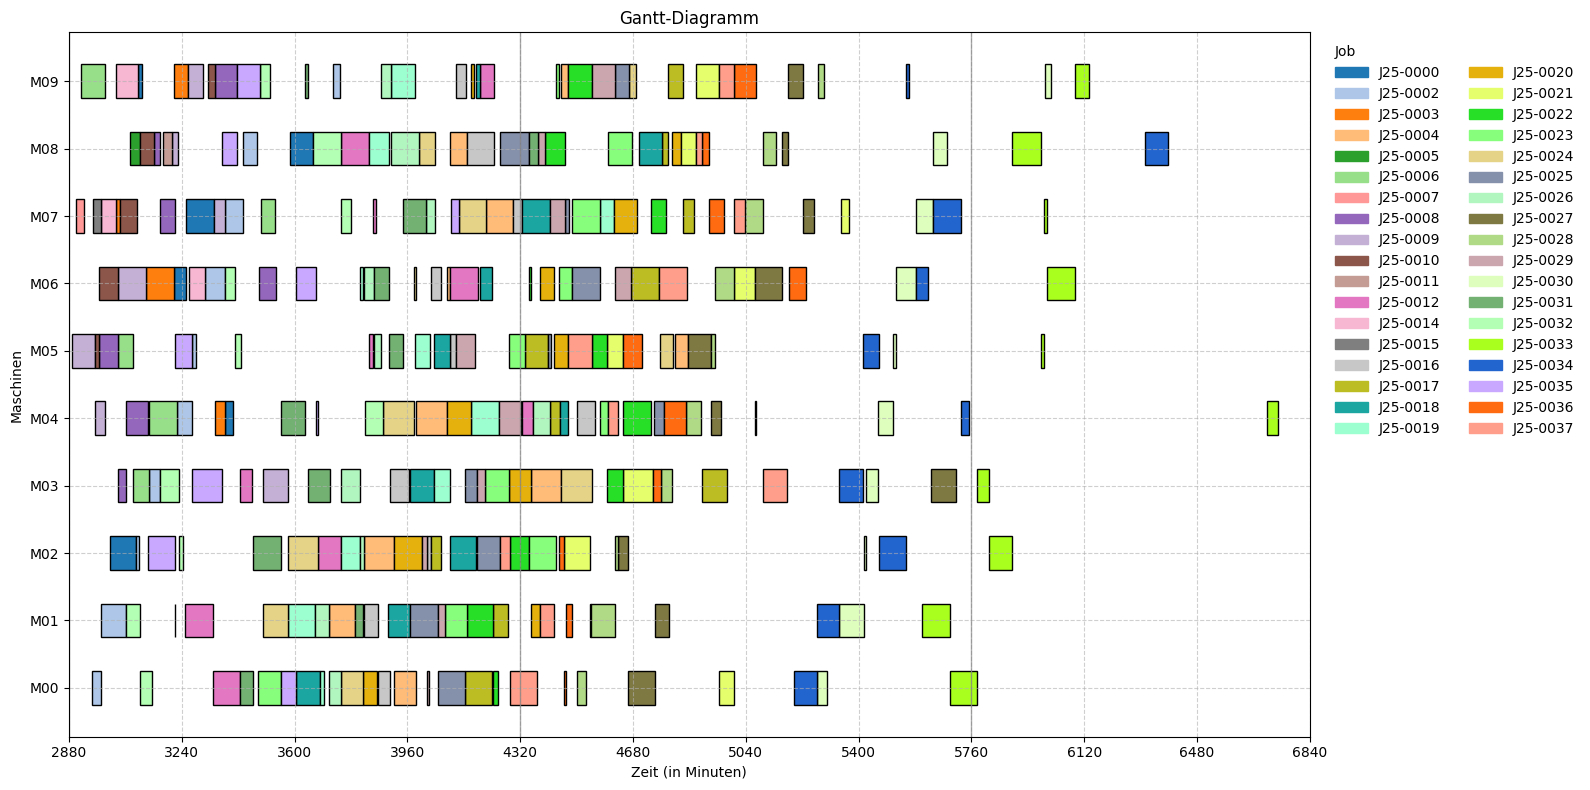

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.


True

In [63]:
schedule, experiment_log = solve_jssp_lateness_with_start_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=None,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=1,
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)


In [64]:
get_comparison_dataframe(df_previous_schedule, df_schedule, comparison_start_time=day_start)

,Original Sequence,Revised Sequence,Levenshtein,Kendall Tau
Machine,,,,
M00,"[J25-0002, J25-0012, J25-0004]","[J25-0002, J25-0012, J25-0004]",0,1.000000
M01,"[J25-0002, J25-0012, J25-0004]","[J25-0002, J25-0012, J25-0004]",0,1.000000
M02,"[J25-0002, J25-0012, J25-0004]","[J25-0002, J25-0012, J25-0004]",0,1.000000
M03,"[J25-0008, J25-0006, J25-0002, J25-0012, J25-0...","[J25-0008, J25-0006, J25-0002, J25-0012, J25-0...",0,1.000000
M04,"[J25-0009, J25-0008, J25-0006, J25-0002, J25-0...","[J25-0009, J25-0008, J25-0006, J25-0002, J25-0...",2,0.928571
M05,"[J25-0010, J25-0008, J25-0006, J25-0002, J25-0...","[J25-0010, J25-0008, J25-0006, J25-0002, J25-0...",0,1.000000
M06,"[J25-0010, J25-0003, J25-0009, J25-0000, J25-0...","[J25-0010, J25-0009, J25-0003, J25-0000, J25-0...",4,0.888889
M07,"[J25-0007, J25-0003, J25-0015, J25-0010, J25-0...","[J25-0007, J25-0015, J25-0003, J25-0010, J25-0...",4,0.927273
M08,"[J25-0005, J25-0010, J25-0008, J25-0011, J25-0...","[J25-0005, J25-0010, J25-0008, J25-0011, J25-0...",0,1.000000


In [65]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean kendall tau: {mean_kendall_tau:.2f}")

Sum Levenshtein: 12 (over 67 shared operations)
Mean kendall tau: 0.96


In [66]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,36,0,0,0


### b) with 'start' deviation penalty


===== EXPERIMENT LOG SUMMARY =====
[EXPERIMENT_INFO]
  total_number_of_operations                        : 291
  number_of_operations_with_previous_schedule       : 71
  number_of_active_operation_to_consider            : 4
  schedule_start                                    : 2880
[EXPERIMENT_CONFIG]
  main_pct                                          : 0.5
  w_t                                               : 5
  w_e                                               : 1
  w_first                                           : 1
  deviation_type                                    : start
  solver_time_limit                                 : 180
  solver_relative_gap_limit                         : 0.05
[MODEL_INFO]
  number_of_variables                               : 945
  number_of_constraints                             : 1214
  number_of_deviation_terms                         : 71
[SOLVER_INFO]
  status                                            : OPTIMAL
  objective_value             

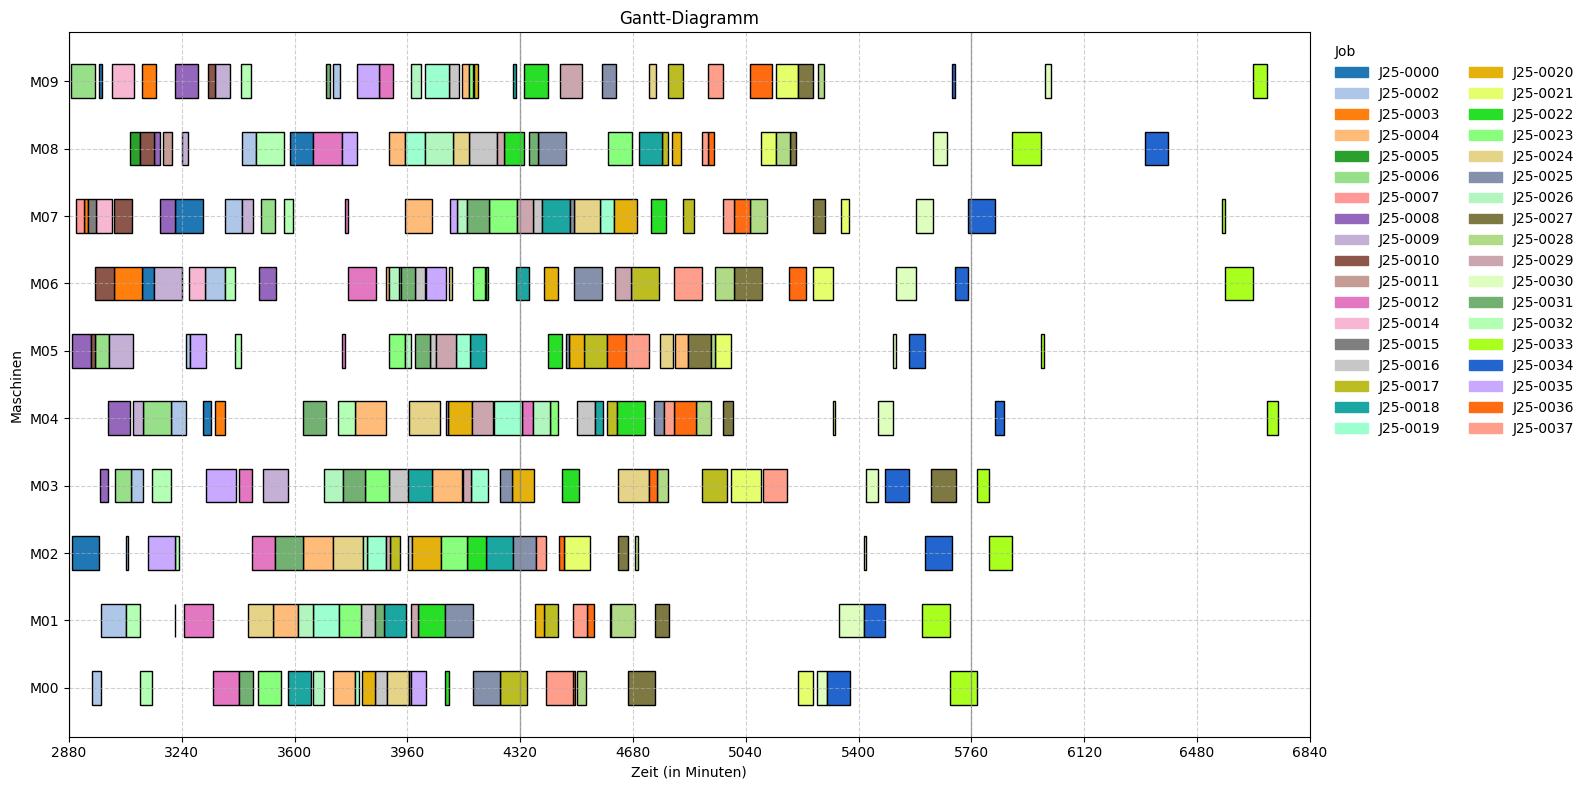

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.

Sum Levenshtein: 6 (over 67 shared operations)
Mean kendall tau: 0.97


In [67]:
schedule, experiment_log = solve_jssp_lateness_with_start_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=previous_schedule,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=(1/2),                  # 50% Lateness, 50% Deviation
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"\nSum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean kendall tau: {mean_kendall_tau:.2f}")

In [68]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,36,0,0,0


### c) with 'order on machines' deviation penalty


===== EXPERIMENT LOG SUMMARY =====
[EXPERIMENT_INFO]
  total_number_of_operations                        : 291
  number_of_operations_with_previous_schedule       : 71
  number_of_active_operation_to_consider            : 4
  schedule_start                                    : 2880
[EXPERIMENT_CONFIG]
  main_pct                                          : 0.5
  w_t                                               : 5
  w_e                                               : 1
  w_first                                           : 1
  deviation_type                                    : order_on_machine
  solver_time_limit                                 : 180
  solver_relative_gap_limit                         : 0.05
[MODEL_INFO]
  number_of_variables                               : 1062
  number_of_constraints                             : 1590
  number_of_deviation_terms                         : 259
[SOLVER_INFO]
  status                                            : OPTIMAL
  objective_value

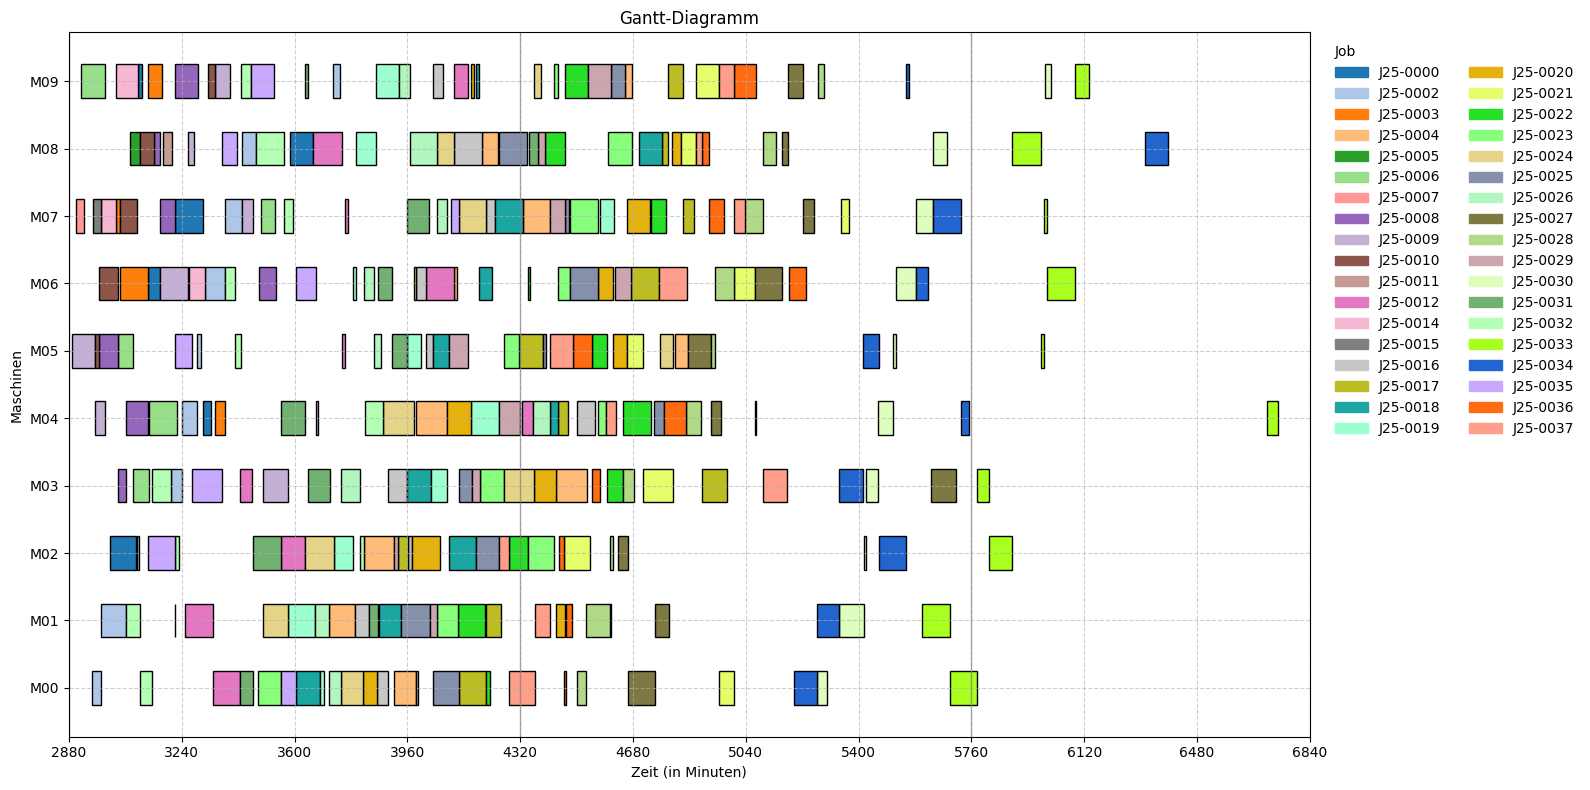

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.

Sum Levenshtein: 4 (over 67 shared operations)
Mean kendall tau: 0.99


In [69]:
schedule, experiment_log = solve_jssp_lateness_with_order_deviation_minimization(
    job_ops=job_ops_dict,
    times_dict=times_dict,
    previous_schedule=previous_schedule,
    active_ops=active_ops,
    w_t=5, w_e=1, w_first=1,
    main_pct=(1/2),                  # 50% Lateness, 50% Deviation
    duration_buffer_factor = 2,
    schedule_start=day_start, msg=False,
    solver_time_limit=max_time, solver_relative_gap_limit=0.05
)

print_experiment_log(experiment_log)

df_schedule = get_schedule_dframe(schedule)
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)

sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"\nSum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean kendall tau: {mean_kendall_tau:.2f}")

In [70]:
df_schedule_with_times = enrich_schedule_dframe(df_schedule, df_jobs_times_current, on= "Job")
df_last_ops_with_metrics = get_jobs_with_lateness_metrics(df_schedule_with_times)
get_jobs_aggregated(df_last_ops_with_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,36,0,0,0


#### Check the conditions of the combined data set from the simulation data with the new schedule

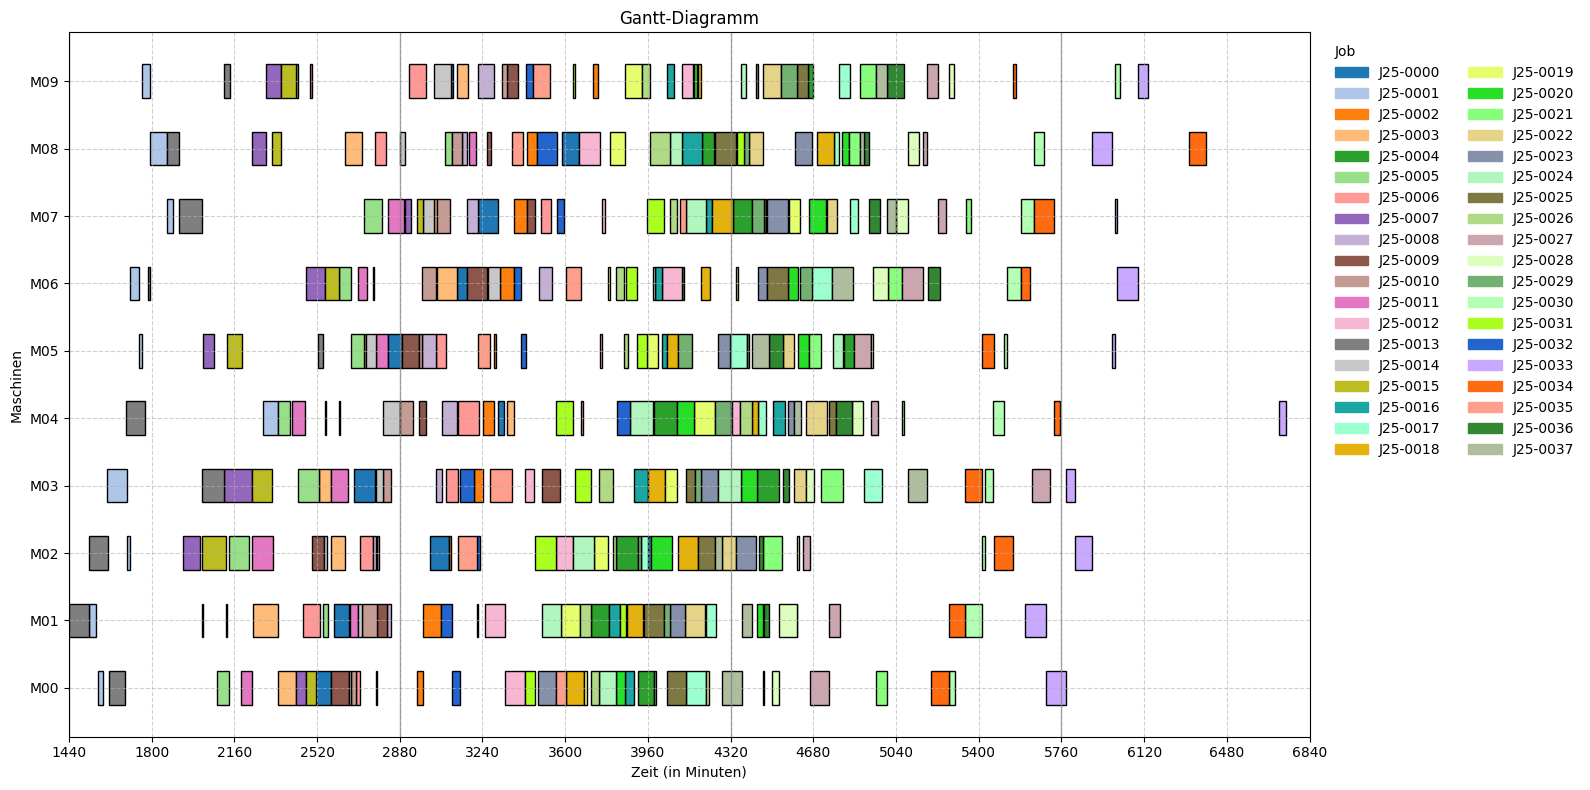

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.


True

In [71]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)

### Simulation

In [72]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0000, Operation 3 resumed on M05 (with 10 minutes left)
[Day 2 00:00:00] Job J25-0011, Operation 8 resumed on M07 (with 20 minutes left)
[Day 2 00:00:00] Job J25-0010, Operation 4 resumed on M04 (with 56 minutes left)
[Day 2 00:00:00] Job J25-0014, Operation 6 resumed on M08 (with 21 minutes left)
[Day 2 00:10:00] Job J25-0000 finished on M05 (after 10 minutes)
[Day 2 00:10:00] Job J25-0009 started on M05
[Day 2 00:20:00] Job J25-0011 finished on M07 (after 20 minutes)
[Day 2 00:21:00] Job J25-0014 finished on M08 (after 21 minutes)
[Day 2 00:24:00] Job J25-0007 started on M07
[Day 2 00:39:00] Job J25-0006 started on M09
[Day 2 00:56:00] Job J25-0010 finished on M04 (after 56 minutes)
[Day 2 00:58:00] Job J25-0007 finished on M07 (after 34 minutes)
[Day 2 01:14:00] Job J25-0002 started on M00
[Day 2 01:16:00] Job J25-0015 started on M07
[Day 2 01:35:00] Job J25-0002 finished on M00 (after 21 minutes)
[Day 2 01:36:00] Job J25-0009 finished on M05 (after 86 minut

In [73]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,3,M05,2828.0,62.0,2890.0
1,J25-0000,4,M02,3010.0,112.0,3122.0
2,J25-0000,5,M09,3129.0,10.0,3139.0
3,J25-0000,6,M06,3156.0,39.0,3195.0
4,J25-0000,7,M07,3233.0,75.0,3308.0
5,J25-0000,8,M04,3309.0,24.0,3333.0
...,...,...,...,...,...,...
154,J25-0035,5,M09,3462.0,65.0,3527.0
155,J25-0035,6,M00,3558.0,43.0,3601.0
156,J25-0035,7,M06,3605.0,94.0,3699.0


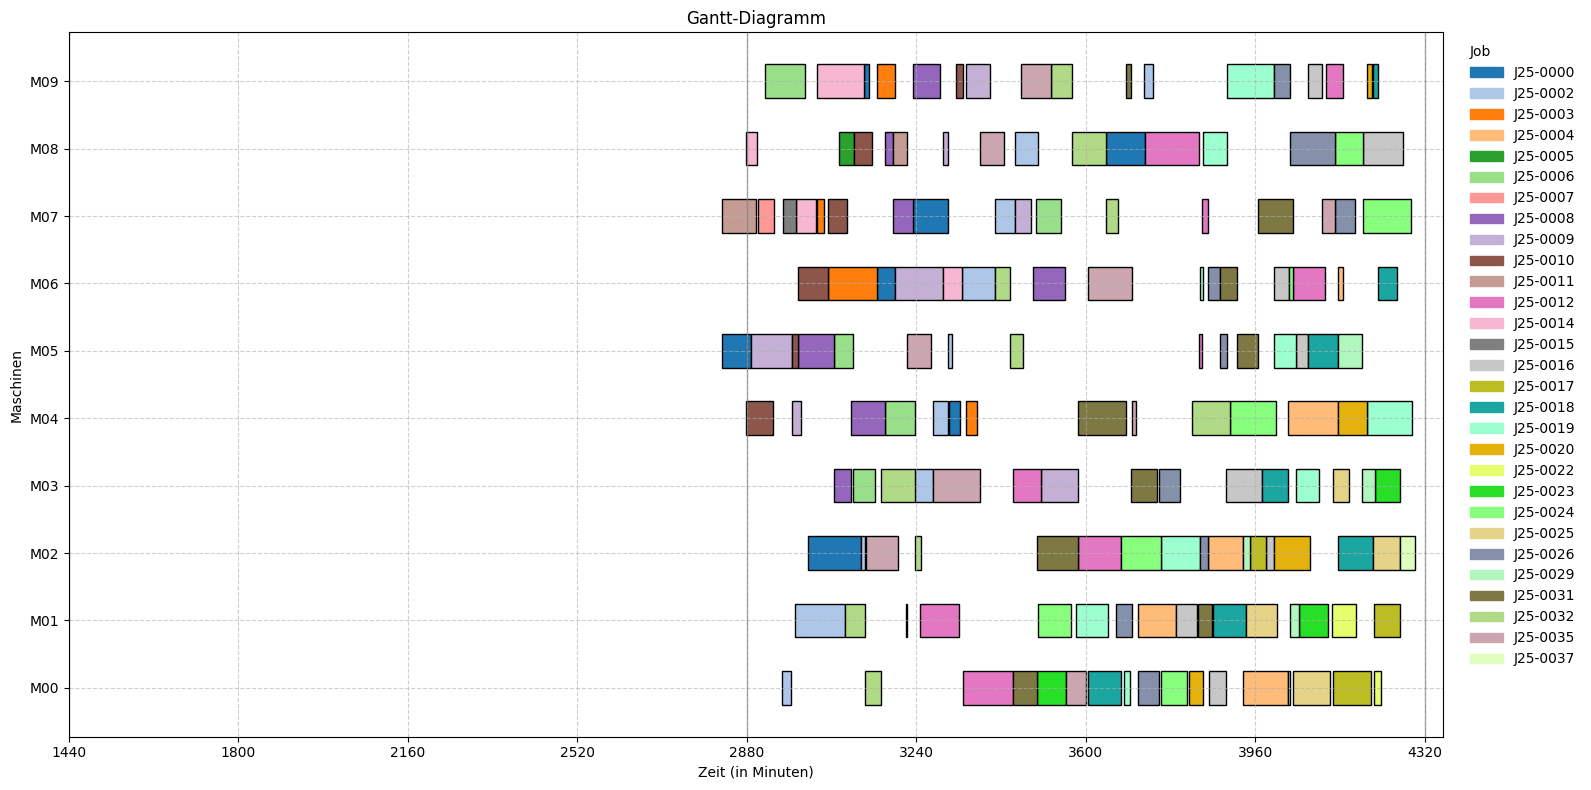

In [74]:
gantt.get_plot(df_execution2, perspective="Machine")

In [75]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Job,Operation,Machine,Start,Processing Time,End,Expected End
0,J25-0004,5,M08,4274.0,56.0,4330.0,4326.0
1,J25-0018,7,M07,4292.0,75.0,4367.0,4381.0
2,J25-0022,2,M02,4300.0,77.0,4377.0,4361.0
3,J25-0023,3,M05,4268.0,53.0,4321.0,4319.0
4,J25-0024,7,M03,4292.0,94.0,4386.0,4390.0
5,J25-0029,5,M04,4294.0,81.0,4375.0,4363.0
6,J25-0037,1,M00,4300.0,79.0,4379.0,4386.0


#### Check the conditions of the combined data set from the two simulation data sets

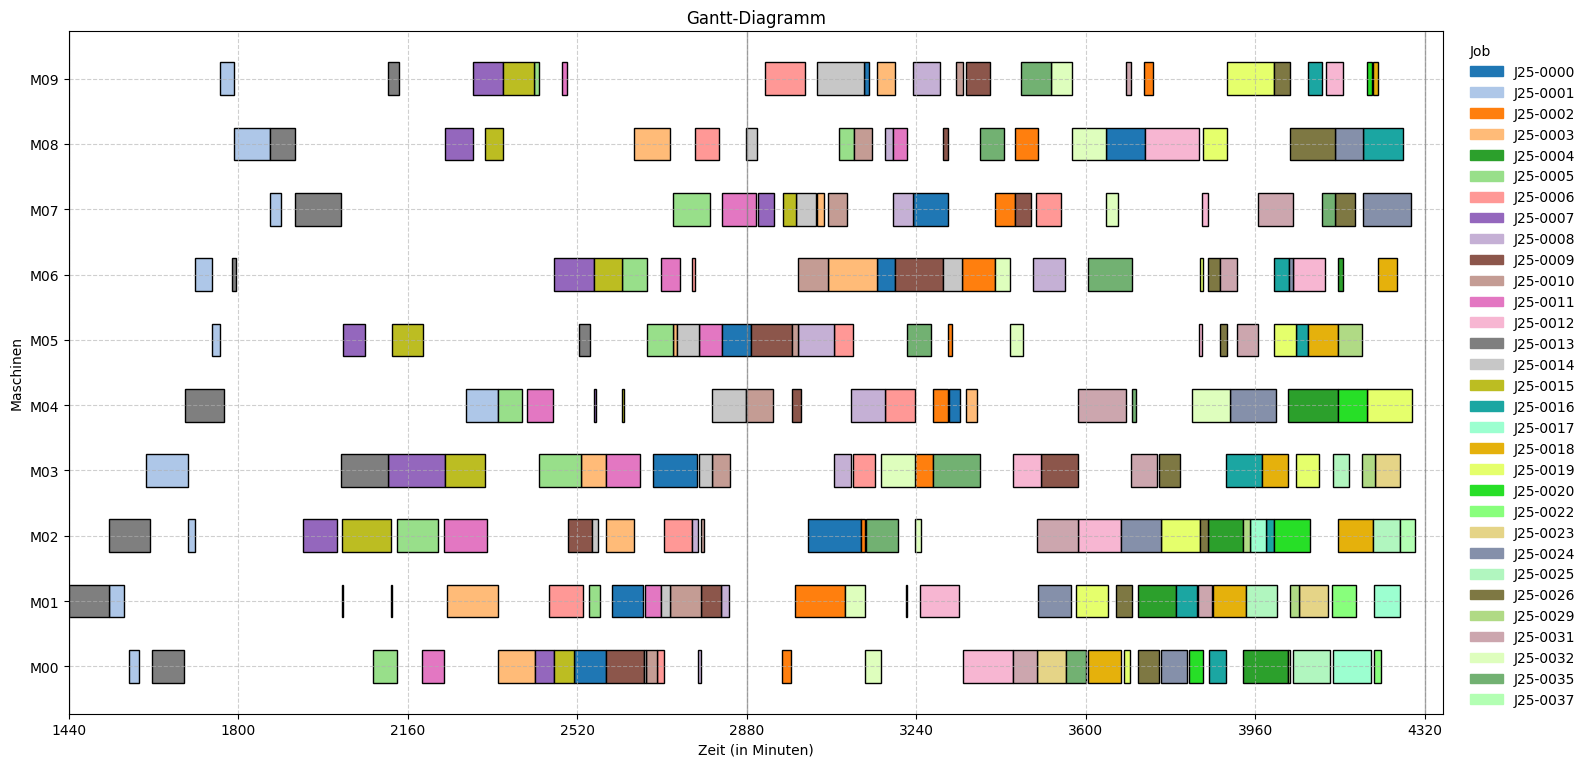

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.


True

In [76]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.check_core_schedule_constraints(df_combined)